In [40]:
!python -V

Python 3.9.12


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [1]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("my_scnd_experiment")

2025/05/16 14:33:55 INFO mlflow.tracking.fluent: Experiment with name 'my_scnd_experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1747406035326, experiment_id='1', last_update_time=1747406035326, lifecycle_stage='active', name='my_scnd_experiment', tags={}>

In [6]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

In [7]:
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

In [8]:
df['duration'] =df.lpep_dropoff_datetime - df.lpep_pickup_datetime

In [9]:
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60) #convert to minutes

In [10]:
df=df[df.trip_type == 2] #Dispatch

In [11]:
df.duration.describe(percentiles=[0.95,0.98,0.99])

count    1238.000000
mean       18.305493
std       108.364382
min         0.000000
50%         1.666667
95%        35.604167
98%        59.339333
99%       149.837833
max      1416.100000
Name: duration, dtype: float64

In [12]:
((df.duration >= 1) & (df.duration <= 60)).mean()

np.float64(0.5169628432956381)

In [13]:
df = df[((df.duration >= 1) & (df.duration <= 60))]

In [14]:
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']

In [15]:
df[categorical] = df[categorical].astype(str)

In [16]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
30,2,2021-01-01 00:35:29,2021-01-01 00:55:15,N,5.0,74,247,1.0,3.64,13.0,...,0.0,0.0,0.0,None,0.3,13.3,2.0,2.0,0.0,19.766667
53,2,2021-01-01 01:54:51,2021-01-01 02:15:35,N,5.0,74,94,1.0,5.82,18.0,...,0.0,0.0,0.0,None,0.3,18.3,2.0,2.0,0.0,20.733333
69,2,2021-01-01 02:42:49,2021-01-01 02:50:59,N,5.0,136,241,1.0,0.57,9.0,...,0.0,0.0,0.0,None,0.3,9.3,2.0,2.0,0.0,8.166667
88,2,2021-01-01 04:52:02,2021-01-01 05:05:01,N,5.0,247,75,1.0,3.43,15.0,...,0.0,0.0,0.0,None,0.3,15.3,2.0,2.0,0.0,12.983333
96,2,2021-01-01 05:52:43,2021-01-01 05:58:02,N,5.0,7,7,1.0,0.65,50.0,...,0.0,7.0,0.0,None,0.3,57.3,1.0,2.0,0.0,5.316667


In [17]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [18]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [19]:
X_train

<640x236 sparse matrix of type '<class 'numpy.float64'>'
	with 1920 stored elements in Compressed Sparse Row format>

In [20]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=112',
 'DOLocationID=116',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=121',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=138',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=143',
 'DOLocationID=145',
 'DOLocationID=146',
 'DOLocationID=147',
 'DOLocationID=148',
 'DOLocationID=151',
 'DOLocationID=152',
 'DOLocationID=156',
 'DOLocationID=159',
 'DOLocationID=16',
 'DOLocationID=161',
 'DOLocationID=162',
 'DOLocationID=163',
 'DOLocationID=165',
 'DOLocationID=166',
 'DOLocationID=167',
 'DOLocationID=168',
 'DOLocationID=169',
 'DOLocationID=17',
 'DOLocationID=170',
 'DOLocationID=173',
 'DOLocationID=174',
 'DOLocationID=177',
 'DOLocationID=179',
 'DOLocationID=18',
 'DOLocationID=182'

In [21]:
target = 'duration'
y_train = df[target].values

In [22]:
y_train

array([19.76666667, 20.73333333,  8.16666667, 12.98333333,  5.31666667,
        1.26666667,  1.6       ,  5.03333333,  1.86666667,  6.38333333,
       34.71666667,  1.35      , 27.23333333,  9.11666667, 26.23333333,
       28.75      , 22.01666667, 21.85      , 20.96666667, 21.61666667,
        9.26666667, 22.63333333, 25.41666667,  1.2       , 16.7       ,
       49.2       ,  7.35      , 14.16666667, 13.58333333, 24.06666667,
       24.2       , 27.21666667, 19.61666667, 12.71666667, 18.83333333,
        6.26666667,  2.53333333, 13.26666667,  7.63333333, 54.71666667,
        3.75      ,  4.15      ,  3.65      , 10.26666667,  5.6       ,
        2.93333333, 33.95      ,  6.53333333, 10.08333333, 21.96666667,
       30.96666667,  5.78333333, 11.05      ,  7.35      , 18.15      ,
       10.25      ,  1.95      ,  1.95      , 38.2       , 12.3       ,
       14.03333333, 16.91666667,  3.83333333, 14.31666667,  7.01666667,
       19.56666667,  6.41666667, 38.48333333, 34.98333333, 10.38

In [23]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [24]:
y_pred = lr.predict(X_train)

/tmp/ipykernel_24307/3882591490.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_24307/3882591490.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train,label='actual')


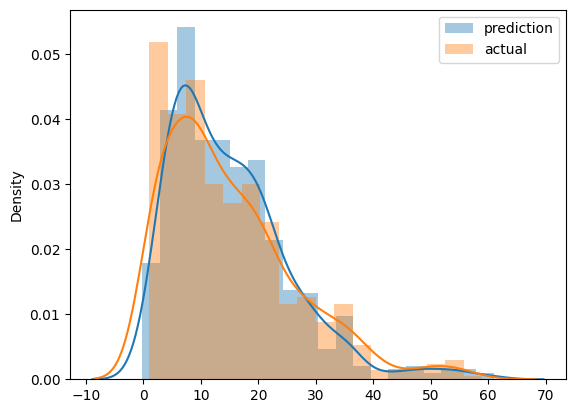

In [25]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train,label='actual')
plt.legend()

In [27]:
import math
rmse = mean_squared_error(y_train, y_pred)
math.sqrt(rmse)

4.803126149499836

In [28]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    
    df['duration'] =df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds()  / 60)
    
    df = df[((df.duration >= 1) & (df.duration <= 60))]
    
    categorical = ['PULocationID','DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [29]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [30]:
len(df_train), len(df_val)

(73908, 61921)

In [31]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [32]:
df_val

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2,2021-02-01 00:34:03,2021-02-01 00:51:58,N,1.0,130,205,5.0,3.66,14.00,...,10.00,0.0,None,0.3,25.30,1.0,1.0,0.00,17.916667,130_205
1,2,2021-02-01 00:04:00,2021-02-01 00:10:30,N,1.0,152,244,1.0,1.10,6.50,...,0.00,0.0,None,0.3,7.80,2.0,1.0,0.00,6.500000,152_244
2,2,2021-02-01 00:18:51,2021-02-01 00:34:06,N,1.0,152,48,1.0,4.93,16.50,...,0.00,0.0,None,0.3,20.55,2.0,1.0,2.75,15.250000,152_48
3,2,2021-02-01 00:53:27,2021-02-01 01:11:41,N,1.0,152,241,1.0,6.70,21.00,...,0.00,0.0,None,0.3,22.30,2.0,1.0,0.00,18.233333,152_241
4,2,2021-02-01 00:57:46,2021-02-01 01:06:44,N,1.0,75,42,1.0,1.89,8.50,...,2.45,0.0,None,0.3,12.25,1.0,1.0,0.00,8.966667,75_42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64567,2,2021-02-28 22:19:00,2021-02-28 22:29:00,None,NaN,129,7,NaN,2.63,10.04,...,0.00,0.0,None,0.3,10.34,NaN,NaN,NaN,10.000000,129_7
64568,2,2021-02-28 23:18:00,2021-02-28 23:27:00,None,NaN,116,166,NaN,1.87,8.33,...,1.89,0.0,None,0.3,10.52,NaN,NaN,NaN,9.000000,116_166
64569,2,2021-02-28 23:44:00,2021-02-28 23:58:00,None,NaN,74,151,NaN,2.40,12.61,...,0.00,0.0,None,0.3,12.91,NaN,NaN,NaN,14.000000,74_151
64570,2,2021-02-28 23:07:00,2021-02-28 23:14:00,None,NaN,42,42,NaN,1.11,11.95,...,0.00,0.0,None,0.3,15.00,NaN,NaN,NaN,7.000000,42_42


In [33]:
categorical = ['PU_DO']#'PULocationID','DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)


In [34]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [36]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

rmse = mean_squared_error(y_val,y_pred)
math.sqrt(rmse)

7.758715208009878

In [38]:
with mlflow.start_run():
    mlflow.set_tag("developer","christian")
    mlflow.log_param("train-data-path","./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path","./data/green_tripdata_2021-02.parquet")
    alpha = 0.001
    mlflow.log_param("alpha",alpha)
    lr = Lasso(alpha)   
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val,y_pred)
    math.sqrt(rmse)
    mlflow.log_metric("rmse",math.sqrt(rmse))

In [75]:
lr = Ridge()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

mean_squared_error(y_val,y_pred,squared=False)

11.342603943214286

In [76]:
with open('models/lin_reg.bin','wb') as f_out:
    pickle.dump((dv,lr),f_out)

FileNotFoundError: [Errno 2] No such file or directory: 'models/lin_reg.bin'

In [ ]:
lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)

mean_squared_error(y_val,y_pred,squared=False)